# The demo of Constrained R-CNN.
<font size=3>Demo script showing detections in sample images and whole testing set.<br> 
See README.md for installation instructions before running.<br> 
For more details, please see our [paper](https://arxiv.org/abs/1911.08217).<br> </font>


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import _init_paths
from model.config import cfg
from model.test import im_detect
from utils.cython_nms import nms
from utils.timer import Timer
from nets.resnet_v1_cbam import resnet_cbam
from nets.res101_v1_C3Rcbam import resnet_C3Rcbam
from PIL import Image, ImageDraw, ImageFont
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import matplotlib
import numpy as np
import os, cv2
import argparse

matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline
# matplotlib.use('Agg')

In [2]:
cfg.TEST.HAS_RPN = True               # Use RPN for proposals
cfg.USE_MASK = True                   # Out put mask
cfg.TEST.MASK_BATCH=8                 # Stage-2 batchsize
data_dir = './test_image/probe/'      # test images directory
dataset = 'NIST'                      # dataset 'NIST, COVER, Columbia, CASIA'

In [3]:
def cal_precision_recall_mae(prediction, gt):
    y_test=gt.flatten()
    y_pred=prediction.flatten()
    precision,recall,thresholds=metrics.precision_recall_curve(y_test,y_pred)
    auc_score = roc_auc_score(y_test, y_pred)
    return precision, recall,auc_score

In [4]:
def cal_fmeasure(precision, recall):

    fmeasure = [[(2 * p * r) / (p + r + 1e-10)] for p, r in zip(precision, recall)]
    fmeasure=np.array(fmeasure)
    fmeasure=fmeasure[fmeasure[:, 0].argsort()]

    max_fmeasure=fmeasure[-1,0]
    return max_fmeasure

In [5]:
import numpy
 
def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.frombuffer ( fig.canvas.tostring_argb(), dtype=numpy.uint8 )
    buf.shape = ( h, w,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = numpy.roll ( buf, 3, axis = 2 )
    return buf
def draw_result(mask_boxes, mask_scores, maskcls_inds, img_add):
    h,w,c=img_add.shape
    img_add = Image.fromarray(cv2.cvtColor(img_add, cv2.COLOR_BGR2RGB))
    fig, ax = plt.subplots()
    img_add=ax.imshow(img_add, aspect='equal')
    for i in range(len(mask_scores)):
        bbox = mask_boxes[i,:]
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=5)
        )
        ax.text(bbox[0], bbox[1] - 22,
                '{:s} '.format(str(classes[int(maskcls_inds[i])])),
                bbox=dict(facecolor='red', alpha=0.8),
                fontsize=38, color='white')

        plt.axis('off')
        plt.draw()
    fig.set_size_inches(w/100.0/3, h/100.0/3)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0)
    plt.margins(0,0)
    plt.close(fig)
    im_result=fig2data(fig)
    return im_result, str(classes[int(maskcls_inds[i])])
def draw_figure(all_image, f1, auc, class_name, dataset_name):
    fig=plt.figure(figsize=(15, 7), edgecolor='black', linewidth=2)
    plt.style.use('ggplot')
    fig_title=dataset_name+': '+class_name+' detection example'
    fig.suptitle(fig_title,fontsize=25,x=0.53,y=1.05, fontstyle='normal', 
                 fontweight='medium',verticalalignment='bottom')
    ax = fig.add_subplot(231)
    ax.set_title('Tampered image', fontsize=15,fontstyle='normal', 
                 fontweight='medium',verticalalignment='bottom')
    ax.imshow(all_image['image_temper'])
    plt.axis('off')
    ax = fig.add_subplot(232)
    ax.set_title('Groundtruth',fontsize=15,fontstyle='normal', 
                 fontweight='medium',verticalalignment='bottom')
    ax.imshow(all_image['groundtruth'], cmap='gray')
    plt.axis('off')
    ax = fig.add_subplot(233)
    ax.set_title('Constrained Conv',fontsize=15,fontstyle='normal', 
                 fontweight='medium',verticalalignment='bottom')
    ax.imshow(all_image['conv'])
    plt.axis('off')
    ax = fig.add_subplot(234)
    ax.set_title('Heatmap',fontsize=15,fontstyle='normal', 
                 fontweight='medium',verticalalignment='bottom')
    ax.imshow(all_image['heatmap'])
    plt.axis('off')
    ax = fig.add_subplot(235)
    ax.set_title('Mask prediction',fontsize=15,fontstyle='normal', 
                 fontweight='medium',verticalalignment='bottom')
    ax.imshow(all_image['mask_pre'])
    plt.axis('off')
    ax = fig.add_subplot(236)
    ax.set_title('Final result',fontsize=15,fontstyle='normal', 
                 fontweight='medium',verticalalignment='bottom')
    ax.imshow(all_image['result'])
    plt.axis('off')
    fig.tight_layout()
    plt.show()

In [6]:
def demo_single(sess, net, image_name,classes, dataset_name):
    try:
        im_file = os.path.join(data_dir, image_name)
    except Exception as e:  # pylint: disable=broad-except
        print(str(e))

    imfil=im_file
    maskpath=str(imfil).replace('probe','mask')
#     authentic_path=str(im_fil).replace('probe','authentic')
    im = cv2.imread(imfil)
    save_id=str(str(imfil.split('/')[-1]).split('.')[0])
    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    # try:

    scores, boxes, feat, s, maskcls_inds, mask_boxes, mask_scores, mask_pred, mask_data,layers= im_detect(sess, net, im)

    timer.toc()
    noise =np.squeeze(layers['noise'])
    noise += cfg.PIXEL_MEANS
    noise_save=noise.copy()
    noise_save=cv2.resize(noise_save,(im.shape[1],im.shape[0]))
#     cv2.imwrite('/media/li/Li/'+save_id+'_tamper.png', im)
#     cv2.imwrite('/media/li/Li/'+save_id+'_noise.png',noise_save)
    batch_ind = np.where(mask_scores > 0.)[0]
    mask_boxes = mask_boxes.astype(int)
    if batch_ind.shape[0] == 0:
        f1 = 1e-10
        auc_score = 1e-10
    else:
        mask_out = np.zeros(im.shape[:2], dtype=np.float)
        for ind in batch_ind:
            height = mask_boxes[ind, 3] - mask_boxes[ind, 1]
            width = mask_boxes[ind, 2] - mask_boxes[ind, 0]
            if width <= 0 or height <= 0:
                continue
            else:
                mask_inbox = cv2.resize(mask_pred[ind, :, :, :], (width, height))
                mask_globe = np.zeros(im.shape[:2], dtype=np.float)
                bbox1 = mask_boxes[ind, :]
                mask_globe[bbox1[1]:bbox1[3], bbox1[0]:bbox1[2]] = mask_inbox
                mask_out = np.where(mask_out >= mask_globe, mask_out, mask_globe)
#         cv2.imwrite('/media/li/Li/' + save_id + '_pre_mask.png', mask_out.copy()*255)
        heatmap = cv2.applyColorMap(np.uint8(255 * mask_out.copy()), cv2.COLORMAP_JET)
#         cv2.imwrite('/media/li/Li/' +save_id + '_heatmap.png', heatmap)

        
        mask_gt=cv2.imread(maskpath)
        mask_gt = cv2.cvtColor(mask_gt, cv2.COLOR_BGR2GRAY)
        ret, mask_gt = cv2.threshold(mask_gt, 127, 1, cv2.THRESH_BINARY)
        mask_gt = mask_gt.astype(np.float32)
        precision, recall, auc_score = cal_precision_recall_mae(mask_out, mask_gt)
        f1 = cal_fmeasure(precision, recall)
        ret,mask_thresh=cv2.threshold(mask_out, 0.5, 1, cv2.THRESH_BINARY)
        img_add = cv2.addWeighted(im, 0.5, heatmap, 0.5,gamma=0,)
        mask_ind=np.where(mask_thresh>0)
        mask_in=im[mask_ind]
        img_add[mask_ind]=mask_in
        
        dets = np.hstack((mask_boxes, mask_scores)).astype(np.float32)
        keep = nms(dets, 0.5)
        mask_boxes=mask_boxes[keep,:]
        mask_scores=mask_scores[keep,:]
        maskcls_inds=maskcls_inds[keep,:]
        
        result, class_name=draw_result(mask_boxes,mask_scores,maskcls_inds,img_add)
#         cv2.imwrite('/media/li/Li/' + save_id + '_result.png', result)
        all_image={}
        all_image['image_temper']=np.array(cv2.cvtColor(im, cv2.COLOR_BGR2RGB),np.uint8)
        all_image['groundtruth']=mask_gt*255
        all_image['conv']=np.array(cv2.cvtColor(noise_save, cv2.COLOR_BGR2RGB), np.uint8)
        all_image['heatmap']=np.array(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB), np.uint8)
        all_image['mask_pre']=cv2.cvtColor(np.array(mask_out*255, np.uint8), cv2.COLOR_GRAY2RGB)
        all_image['result']=np.array(result,np.uint8)
        draw_figure(all_image, f1, auc_score, class_name, dataset_name)

    return f1, auc_score

In [7]:
def demo_all(sess, net, image_path, mask_path, classes, dataset_name):
    try:
        im_file = os.path.join(image_path)
    except Exception as e:  # pylint: disable=broad-except
        print(str(e))
#     print(image_path)
#     print(im_file)
    imfil=im_file
#     authentic_path=str(im_fil).replace('probe','authentic')
    im = cv2.imread(imfil)
    save_id=str(str(imfil.split('/')[-1]).split('.')[0])
    # Detect all object classes and regress object bounds
    _t = {'im_detect': Timer(), 'out_mask': Timer()}
    _t['im_detect'].tic()
    # try:

    scores, boxes, feat, s, maskcls_inds, mask_boxes, mask_scores, mask_pred, mask_data,layers= im_detect(sess, net, im)

    _t['im_detect'].toc()
    _t['out_mask'].tic()
    batch_ind = np.where(mask_scores > 0.)[0]
    mask_boxes = mask_boxes.astype(int)
    if batch_ind.shape[0] == 0:
        f1 = 1e-10
        auc_score = 1e-10
    else:
        mask_out = np.zeros(im.shape[:2], dtype=np.float)
        for ind in batch_ind:
            height = mask_boxes[ind, 3] - mask_boxes[ind, 1]
            width = mask_boxes[ind, 2] - mask_boxes[ind, 0]
            if width <= 0 or height <= 0:
                continue
            else:
                mask_inbox = cv2.resize(mask_pred[ind, :, :, :], (width, height))
                mask_globe = np.zeros(im.shape[:2], dtype=np.float)
                bbox1 = mask_boxes[ind, :]
                mask_globe[bbox1[1]:bbox1[3], bbox1[0]:bbox1[2]] = mask_inbox
                mask_out = np.where(mask_out >= mask_globe, mask_out, mask_globe)

        mask_gt=cv2.imread(mask_path)
        mask_gt = cv2.cvtColor(mask_gt, cv2.COLOR_BGR2GRAY)
        ret, mask_gt = cv2.threshold(mask_gt, 127, 1, cv2.THRESH_BINARY)
        mask_gt = mask_gt.astype(np.float32)
        precision, recall, auc_score = cal_precision_recall_mae(mask_out, mask_gt)
        f1 = cal_fmeasure(precision, recall)
    _t['out_mask'].toc()
    return f1, auc_score, _t

In [8]:
# set config
tfconfig = tf.ConfigProto(allow_soft_placement=True)
tfconfig.gpu_options.allow_growth = True

# load network
if dataset == 'NIST':
    tfmodel = os.path.join('./data/NIST_weights/res101_mask_iter_60000.ckpt')
    classes=('authentic','splice','removal','copy-move')
    im_names=['NC2016_7894.png',
              'NC2016_6704.png',
              'NC2016_7065.png']
    dataset_path='./dataset/NIST2016/'
    list_name='NIST_test_new_2.txt'
elif dataset == 'COVER':
    tfmodel = os.path.join('./data/COVER_weights/res101_mask_iter_4000.ckpt')
    classes=('authentic','tampered')
    im_names=['COVER_9.png']
    dataset_path='./dataset/cover/'
    list_name='cover_test_single.txt'
elif dataset == 'CASIA':
    tfmodel = os.path.join('./data/CASIA_weights/res101_mask_iter_110000.ckpt')
    classes=('authentic','tampered')
    im_names=['CASIA_ani0036_ani0066_A.png']
    dataset_path='./dataset/CASIA/'
    list_name='test_all_single.txt'
elif dataset == 'Columbia':
    tfmodel = os.path.join('./data/CASIA_weights/res101_mask_iter_110000.ckpt')
    classes=('authentic','tampered')
    im_names=['Columbia.png']
    dataset_path='./dataset/Columbia/'
    list_name='test_all_single.txt'
else:
    raise NotImplementedError
if not os.path.isfile(tfmodel + '.meta'):
    raise IOError(('{:s} not found.\nDid you download the proper networks from '
                   'our server and place them properly?').format(tfmodel + '.meta'))
# init session
sess = tf.Session(config=tfconfig)
net = resnet_C3Rcbam(batch_size=1, num_layers=101)
net.create_architecture(sess, "TEST", len(classes),
                        tag='default', anchor_scales=[8, 16, 32, 64],
                        anchor_ratios=[0.5, 1, 2])
print('Loaded network {:s}'.format(tfmodel))
saver = tf.train.Saver()
saver.restore(sess, tfmodel)

Loaded network ./data/NIST_weights/res101_mask_iter_60000.ckpt


~~~~~~~~~~~~~~~start~~~~~~~~~~~~~~~~~~~~


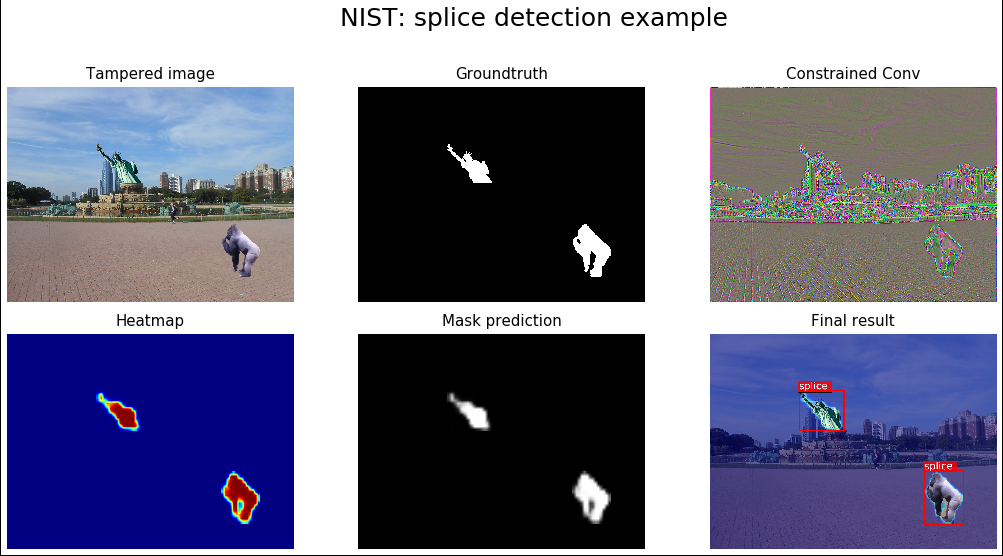

~~~~~~~~~~~~~~~~~~
|F1  is 0.903996 |
|AUC is 0.999111 |
~~~~~~~~~~~~~~~~~~


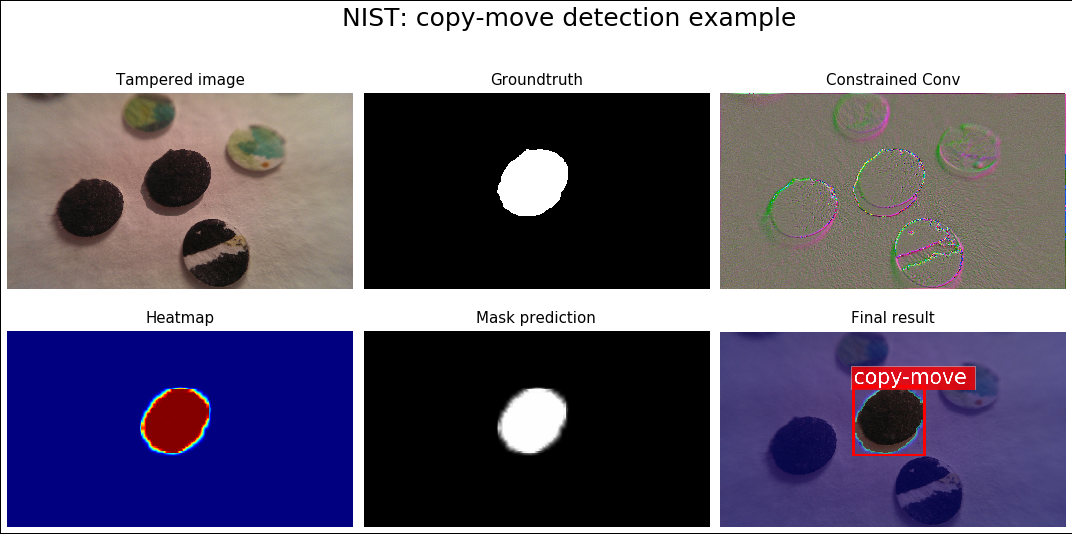

~~~~~~~~~~~~~~~~~~
|F1  is 0.983870 |
|AUC is 0.999948 |
~~~~~~~~~~~~~~~~~~


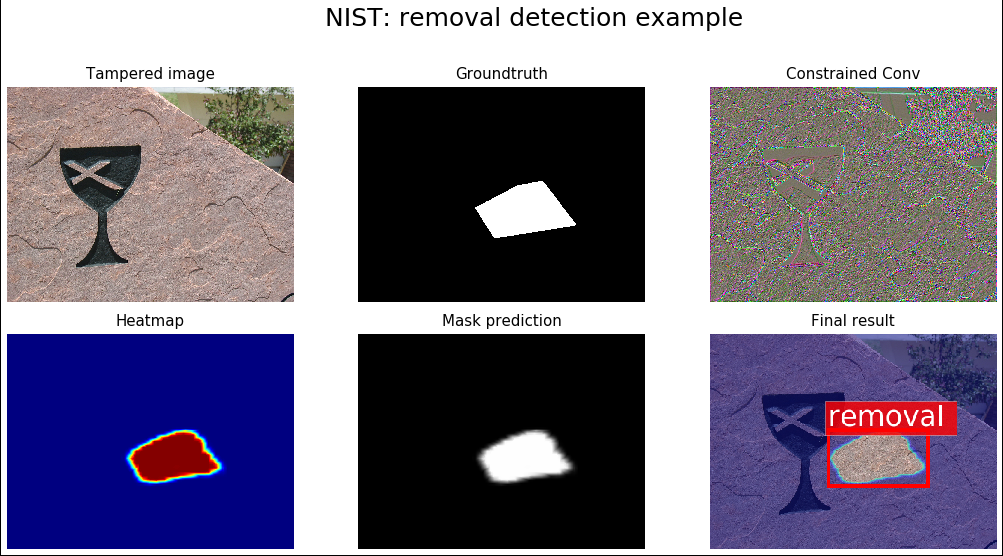

~~~~~~~~~~~~~~~~~~
|F1  is 0.969666 |
|AUC is 0.999799 |
~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~end~~~~~~~~~~~~~~~~~~~~


In [9]:
# test single image
print('~~~~~~~~~~~~~~~start~~~~~~~~~~~~~~~~~~~~')
for im_name in im_names:
    f1, auc_score=demo_single(sess, net, im_name,classes, dataset)
    print('~~~~~~~~~~~~~~~~~~')
    print('|F1  is %5f |'%f1)
    print('|AUC is %5f |'%auc_score)
    print('~~~~~~~~~~~~~~~~~~')

print('~~~~~~~~~~~~~~~end~~~~~~~~~~~~~~~~~~~~')

In [10]:
# Testing on whole testing set.
# All image is resized to their original size. 
# The size of image in NIST16 dataset is very large, so the testing process takes longer.

print('~~~~~~~~~~~~~~~start~~~~~~~~~~~~~~~~~~~~')
with open(os.path.join(dataset_path, list_name), 'r') as f:
    im_names = f.readlines()
    im_ind=1
    im_num=len(im_names)
    f1_scores=[]
    aucs=[]
    for file in im_names:
        file=str(file).split(' ')[0]+'.png'
        im_name = file.split(' ')[0].split('/')[-1]
        
        image_path=dataset_path+'probe/'+file
        if dataset == 'COVER':
            mask_name=str(file).split('_')[1]+'forged.tif'
        else:
            mask_name=file
        mask_path=dataset_path+'mask/'+mask_name
        f1_score,auc,_t = demo_all(sess, net, image_path, mask_path, classes, dataset)
        f1_scores.append(f1_score)
        aucs.append(auc)
        avg_time=(_t['im_detect'].average_time+_t['out_mask'].average_time)/2.0
        print('-> {:d}/{:d} images  |  time: {:.3f} s  |  F1 score: {:.3f}  |  AUC: {:.3f}'.format(im_ind, im_num, avg_time, f1_score, auc))
        im_ind+=1
    print('~~~~~~~~~~~~~~~~~~')
    print('|Dataset : ',dataset,' |')
    print('|F1  is %5f |'%np.mean(np.array(f1_scores)))
    print('|AUC is %5f |'%np.mean(np.array(aucs)))
    print('~~~~~~~~~~~~~~~~~~')

print('~~~~~~~~~~~~~~~end~~~~~~~~~~~~~~~~~~~~')


~~~~~~~~~~~~~~~start~~~~~~~~~~~~~~~~~~~~
-> 1/160 images  |  time: 0.213 s  |  F1 score: 0.935  |  AUC: 0.990
-> 2/160 images  |  time: 6.330 s  |  F1 score: 0.982  |  AUC: 1.000
-> 3/160 images  |  time: 1.388 s  |  F1 score: 0.880  |  AUC: 1.000
-> 4/160 images  |  time: 0.355 s  |  F1 score: 0.917  |  AUC: 1.000
-> 5/160 images  |  time: 1.941 s  |  F1 score: 0.961  |  AUC: 1.000
-> 6/160 images  |  time: 5.312 s  |  F1 score: 0.966  |  AUC: 1.000
-> 7/160 images  |  time: 2.354 s  |  F1 score: 0.948  |  AUC: 0.989
-> 8/160 images  |  time: 1.711 s  |  F1 score: 0.943  |  AUC: 1.000
-> 9/160 images  |  time: 2.755 s  |  F1 score: 0.955  |  AUC: 0.998
-> 10/160 images  |  time: 0.092 s  |  F1 score: 0.906  |  AUC: 0.974
-> 11/160 images  |  time: 0.113 s  |  F1 score: 0.743  |  AUC: 0.998
-> 12/160 images  |  time: 6.557 s  |  F1 score: 0.984  |  AUC: 1.000
-> 13/160 images  |  time: 5.465 s  |  F1 score: 0.979  |  AUC: 1.000
-> 14/160 images  |  time: 5.122 s  |  F1 score: 0.979  | 

-> 118/160 images  |  time: 3.135 s  |  F1 score: 0.977  |  AUC: 1.000
-> 119/160 images  |  time: 2.538 s  |  F1 score: 0.917  |  AUC: 0.999
-> 120/160 images  |  time: 1.696 s  |  F1 score: 0.972  |  AUC: 1.000
-> 121/160 images  |  time: 5.118 s  |  F1 score: 0.979  |  AUC: 1.000
-> 122/160 images  |  time: 6.211 s  |  F1 score: 0.951  |  AUC: 0.994
-> 123/160 images  |  time: 1.660 s  |  F1 score: 0.979  |  AUC: 1.000
-> 124/160 images  |  time: 1.622 s  |  F1 score: 0.977  |  AUC: 1.000
-> 125/160 images  |  time: 2.687 s  |  F1 score: 0.962  |  AUC: 1.000
-> 126/160 images  |  time: 2.697 s  |  F1 score: 0.943  |  AUC: 0.995
-> 127/160 images  |  time: 1.706 s  |  F1 score: 0.939  |  AUC: 1.000
-> 128/160 images  |  time: 1.602 s  |  F1 score: 0.864  |  AUC: 1.000
-> 129/160 images  |  time: 2.434 s  |  F1 score: 0.973  |  AUC: 0.996
-> 130/160 images  |  time: 2.361 s  |  F1 score: 0.851  |  AUC: 0.998
-> 131/160 images  |  time: 1.702 s  |  F1 score: 0.972  |  AUC: 1.000
-> 132